In [1]:
import numpy as np
import math
import time
import pickle
from scipy import optimize
#import pymeshlab
#import potpourri3d as pp3d
import polyscope as ps
from barmesh.tribarmes import trianglebarmesh
from barmesh.basicgeo import P3
import barmesh.geodesicUtils as geo

In [2]:
fname = 'geometry/PV/PV-med.stl'
tbm = trianglebarmesh.TriangleBarMesh(fname)
V = tbm.GetVertices()
F = tbm.GetFaces()
n = tbm.GetNormals()

In [3]:
geopaths=[]
curvs = []
faces =[]
barF,bGoRightF,lamF,barB,bGoRightB,lamB = [],[],[],[],[],[]
select = 0
thetas = ()
maxPathLength = 1000
badFaces = []
edgeBars = tbm.GetEdgeBars()
badEdgeBars = []
geolines =[]

def init_path(startFace):
    global geopaths
    global curvs
    global faces
    global barF,bGoRightF,lamF,barB,bGoRightB,lamB
    global thetas
    geopaths=[]
    curvs = []
    faces =[]
    barF,bGoRightF,lamF,barB,bGoRightB,lamB = [],[],[],[],[],[]
    x,y,z = 0,0,0
    for nn in tbm.faces[startFace].nodes:
        x += tbm.nodes[nn].p.x/3
        y += tbm.nodes[nn].p.y/3
        z += tbm.nodes[nn].p.z/3

    startPt = P3(x,y,z)#
    ref90 = P3(1,0,0)# A reference direction approximately perpendicular to the axis of the part
    ref0 = P3.Cross(ref90,tbm.faces[startFace].normal)
    thetas = np.arange(0,180,30)

    barsints =[]
    for theta in thetas:
        startVec = rotAxisAngle(ref0,tbm.faces[startFace].normal,theta)
        barsint =[]
        #find which bars intersect with the start vector
        for b in tbm.faces[startFace].bars:
            p1 = b.GetNodeFore(True).p
            vec1 = b.GetNodeFore(False).p-b.GetNodeFore(True).p
            try:
                Pint, lam = find_intersection(p1,vec1,startPt,startVec,tol=1e-4)
            except:
                lam = -1
                print('Error finding instersection between starting lines and edge of face, try specifying ref90 in different plane')
            if 0 < lam < 1:
                barsint.append((b,1-lam))
        barsints.append(barsint)

    for barsint in barsints:
        barF.append(barsint[0][0])
        bGoRightF.append(barF[-1].faceleft == startFace)
        lamF.append(barsint[0][1])
        barB.append(barsint[1][0])
        bGoRightB.append(barB[-1].faceleft == startFace)
        lamB.append(barsint[1][1])
        geopaths.append([startPt])
        curvs.append([0])
        faces.append([startFace])
        

def draw_paths():
    global geolines
    global select
    global badEdgeBars
    thetas = np.arange(0,180,90)
    if ps.get_selection()[1] != select:
        select = ps.get_selection()[1]
        if len(V) < select < (len(V)+len(F)):
            fselect = select - len(V)
            print('face',fselect)
        else:
            return
    else:
        return
    x,y,z = 0,0,0
    for nn in tbm.faces[fselect].nodes:
        x += tbm.nodes[nn].p.x/3
        y += tbm.nodes[nn].p.y/3
        z += tbm.nodes[nn].p.z/3

    startPt = P3(x,y,z)
    ref90 = P3(1,0,0)
    geolines =[]
    for th in thetas:
        print('calculating',th)
        geolineDouble = geo.createDoubleGeoLine(tbm, startPt, fselect, th, ref90,calc_thick = False, maxPathLength=1000)
        geolines.append(geolineDouble)
                
    for i in range(len(geolines)):
        if len(geolines[i]['pts'])>0:
            ps_geopath = ps.register_curve_network(str(thetas[i])+'deg', geo.P3list2array(geolines[i]['pts']), 'line')
            if len(geolines[i]['curvs']) == len(geolines[i]['pts']):
                ps_geopath.add_scalar_quantity("curvature", np.array(geolines[i]['curvs']), defined_on='nodes', enabled=True,  cmap='coolwarm',vminmax=(-0.005, 0.005))  
                

def increment_path():
    global geopaths
    global curvs
    global faces
    global barF,bGoRightF,lamF,barB,bGoRightB,lamB
    global select
    global thetas
    if ps.get_selection()[1] != select:
        select = ps.get_selection()[1]
        if len(V) < select < (len(V)+len(F)):
            fselect = select - len(V)
            print('face',fselect)
            init_path(fselect)
        
    allfinished = True
    for i in range(len(thetas)):
        if barF[i]==None and barB[i] ==None:
            f=True
        else:
            f =False
        allfinished = allfinished and f
    
    for i in range(len(thetas)):
        if allfinished: break
        if barF[i] != None:
            if bGoRightF[i]:
                faces[i].append(barF[i].faceright)
            else:
                faces[i].append(barF[i].faceleft)
            #print('face: ',faces[-1])
            c, barF[i], lamF[i], bGoRightF[i] = geo.GeoCrossBar(geopaths[i][-1], barF[i], lamF[i], bGoRightF[i])
            geopaths[i].append(c)
            if faces[i][-1] != None:
                CClast = geopaths[i][-1]-geopaths[i][-2]
                curvature = geo.P3.Dot(tbm.faces[faces[i][-1]].normal,CClast)/P3.Len(tbm.faces[faces[i][-1]].normal)
                curvs[i].append(curvs[i][-1]*0.75 + curvature*0.25)
            elif faces[i][-1] == None:
                curvs[i].append(curvs[i][-1])

        if barB[i] != None:
            if bGoRightB[i]:
                faces[i].insert(0,barB[i].faceright)
            else:
                faces[i].insert(0,barB[i].faceleft)
            #print('face: ',faces[-1])
            c, barB[i], lamB[i], bGoRightB[i] = geo.GeoCrossBar(geopaths[i][0], barB[i], lamB[i], bGoRightB[i])
            geopaths[i].insert(0,c)
            if faces[i][0] != None:
                CClast = geopaths[i][0]-geopaths[i][1]
                curvature = geo.P3.Dot(tbm.faces[faces[i][0]].normal,CClast)/P3.Len(tbm.faces[faces[i][0]].normal)
                curvs[i].insert(0,curvs[i][0]*0.75 + curvature*0.25)
            elif faces[i][0] == None:
                curvs[i].insert(0,curvs[i][0])
    for i in range(len(geopaths)):
        if allfinished: break
        ps_geopath = ps.register_curve_network(str(thetas[i])+'deg', P3list2array(geopaths[i]), 'line')
        if len(curvs[i]) == len(geopaths[i]):
            ps_geopath.add_scalar_quantity("curvature", -np.array(curvs[i]), defined_on='nodes', enabled=True,  cmap='coolwarm',vminmax=(-0.005, 0.005))

        
def selectBadFaces():
    global badFaces
    global select
    global edgeBars
    global badEdgeBars
    edgePts = []
    if ps.get_selection()[1] != select:
        select = ps.get_selection()[1]
        if len(V) < select < (len(V)+len(F)):
            fselect = select - len(V)
            print('face',fselect)
            badFaces.append(fselect)
            for b in tbm.faces[fselect].bars:
                for eb in edgeBars:
                    if b == eb:
                        badEdgeBars.append(eb)
                        eb.badedge = True
            eb1 = badEdgeBars[-1]
            goodEdgeBars = edgeBars
            for i in range(len(goodEdgeBars)):
                for eb2 in goodEdgeBars:
                    if (eb1.GetNodeFore(True) == eb2.GetNodeFore(True) or eb1.GetNodeFore(True) == eb2.GetNodeFore(False) or
                        eb1.GetNodeFore(False) == eb2.GetNodeFore(True) or eb1.GetNodeFore(False) == eb2.GetNodeFore(False)):
                        #print('match found at',eb2.i)
                        badEdgeBars.append(eb2)
                        eb2.badedge = True
                        goodEdgeBars.remove(eb2)
                        edgePts.append(eb2.GetNodeFore(True).p)
                        eb1 = eb2
                        break
            for b in badEdgeBars:
                if b.faceleft:
                    badFaces.append(b.faceleft)
                if b.faceright:
                    badFaces.append(b.faceright)
            col =[]
            B=(0.1,0.1,1)
            R=(1,0.1,0.1)
            badFaces = list(set(badFaces))
            for f in tbm.faces:
                bad = False
                for bf in badFaces:
                    if bf == f.i:
                        col.append(R)
                        bad = True
                if not bad:
                    col.append(B)
            #ps_surf = ps.register_surface_mesh("my mesh", V, F, smooth_shade=False)
            ps_surf.add_color_quantity("bad faces", np.array(col), defined_on='faces',enabled = True)
            if edgePts:
                ps_edgePts = ps.register_point_cloud('edgePts', geo.P3list2array(edgePts))
            
            

    else:
        return

In [4]:
#CLICK A FACE ADJENCENT TO AN EDGE TO BE AVOIDED

ps.init()

ps_surf = ps.register_surface_mesh("my mesh", V, F, edge_width = 1, smooth_shade=False)

ps.set_user_callback(selectBadFaces)
ps.show()
ps.clear_user_callback()
goodEdgeBars = geo.findGoodEdge(edgeBars,badEdgeBars)
goodEdgeBars = geo.sortBars(tbm, goodEdgeBars)

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 4.6 (Core Profile) Mesa 21.2.6


In [12]:
# Create seed points along a line
spacing = 6
spacetonext = spacing
b = goodEdgeBars[0]
if b.faceright:
    bFR = True
    face = b.faceright
    bFor = False
else:
    bFR = False
    face = b.faceleft
    bFor = True
frontPt = b.GetNodeFore(bFR).p
backPt = b.GetNodeFore(not bFR).p
v = backPt - frontPt
firstSeed = frontPt + v*1e-3
seeds = {'pts':[firstSeed],'faces':[face],'ref90s':[v],'bFor':[bFor],'thetas':[0]}
#seeds = {'pts':[],'faces':[],'ref90s':[],'bFor':[]}
for b in goodEdgeBars:
    bPtPlaced = False
    #print()
    #print('spacetonext',spacetonext, 'bar', b.i,'bFR',bFR)
    
    if b.faceright:
        bFR = True
        face = b.faceright
        bFor = False
    else:
        bFR = False
        face = b.faceleft
        bFor = True
    frontPt = b.GetNodeFore(bFR).p
    backPt = b.GetNodeFore(not bFR).p
    v = backPt - frontPt
    #print('len v',v.Len())
    while v.Len() > spacetonext:
        frontPt += (v * (spacetonext/v.Len()))
        v = b.GetNodeFore(bFR).p - frontPt
        spacetonext = spacing
        seeds['pts'].append(frontPt)
        seeds['faces'].append(face)
        seeds['bFor'].append(bFor)
        seeds['ref90s'].append(v)
        seeds['thetas'].append(0)
        bPtPlaced = True
        #print('placing pt', frontPt)
        #print('dist to last', (frontPt - seeds['pts'][-2]).Len())
    if bPtPlaced:
        spacetonext -= (backPt - seeds['pts'][-1]).Len()
    else:
        spacetonext -= v.Len()
        #print('OI!!!!!!!!!!!!!!')

In [30]:
i =0
geoline = geo.createGeoLine(tbm, seeds['pts'][0],
                        seeds['faces'][0], theta=89,
                        ref90= seeds['ref90s'][0],
                        calc_thick = False, tw = 6.35, forward = False, maxPathLength = 1000)

edge reached on path 89 deg


In [6]:
ps.init()

ps_SP = ps.register_point_cloud("seedpts", geo.P3list2array(seeds['pts']))
#ps_SP1 = ps.register_point_cloud("Start1", P3list2array([start1]))
ps_SP.add_vector_quantity("ref90", geo.P3list2array(seeds['ref90s']))
#ps_SP.add_vector_quantity("ref0", geo.P3list2array(seeds['ref0s']))
#ps_SP.add_vector_quantity("startVec", geo.P3list2array(seeds['startVecs']))
ps.register_curve_network('geoline', geo.P3list2array(geoline['pts']), 'line')
ps.show()

NameError: name 'seeds' is not defined

In [8]:
def findMinWind(seeds,incr=10, tol = 0.1):
    for i in range(len(seeds['pts'])):
        inc = incr
        valid_last = False
        theta = 0
        while inc > tol:
            #print('testing angle',theta)
            startPt = seeds['pts'][i]
            ref90 = seeds['ref90s'][i]
            startFace =seeds['faces'][i]
            forward = seeds['bFor'][i]
            geoline = geo.createGeoLine(tbm, startPt, startFace, theta, ref90, calc_thick = False, forward = forward, maxPathLength = 1000)
            theta_last = theta
            if len(geoline['pts']) < 3:
                geoline = geo.createGeoLine(tbm, startPt, startFace, theta, ref90, calc_thick = False, forward = not forward, maxPathLength = 1000)
            if geoline['valid'] != valid_last:
                inc /= 2
            valid_last = geoline['valid']
            if geoline['valid']:
                #print('geoline valid')
                theta -= inc
            else:
                #print('geoline invalid')
                theta += inc
        print('Min angle for seed',i,':', theta_last)
        seeds['thetas'][i] = theta_last    
    
    
findMinWind(seeds)

edge reached on path 0
last bar 2 False
edge reached on path 0
last bar 15982 True
PATH FAIL: bad edge reached
edge reached on path 10
last bar 2 False
edge reached on path 10
last bar 16824 True
PATH FAIL: bad edge reached
edge reached on path 20
last bar 2 False
edge reached on path 20
last bar 19940 True
PATH FAIL: bad edge reached
edge reached on path 30
last bar 2 False
edge reached on path 30
last bar 37833 False
edge reached on path 25.0
last bar 2 False
edge reached on path 25.0
last bar 39265 False
edge reached on path 20.0
last bar 2 False
edge reached on path 20.0
last bar 19940 True
PATH FAIL: bad edge reached
edge reached on path 22.5
last bar 2 False
edge reached on path 22.5
last bar 39660 False
edge reached on path 21.25
last bar 2 False
edge reached on path 21.25
last bar 20891 True
PATH FAIL: bad edge reached
edge reached on path 21.875
last bar 2 False
edge reached on path 21.875
last bar 20891 True
PATH FAIL: bad edge reached
edge reached on path 22.5
last bar 2 Fal

In [20]:
geoplies = [geo.createPly(tbm,seeds)]
for i in range(22,80,2):
    ply = geo.createPly(tbm,seeds,i)
    if len(ply[0]) == len(seeds['pts']):
        print('ADDING PLY angle',i)
        geoplies.append(ply)

edge reached on path 22.5
last bar 2 False
edge reached on path 22.5
last bar 39660 False
edge reached on path 22.1875
last bar 38564 False
edge reached on path 22.65625
last bar 37463 False
edge reached on path 22.5
last bar 3395 False
edge reached on path 22.5
last bar 35830 False
edge reached on path 22.1875
last bar 34434 False
edge reached on path 22.65625
last bar 33023 False
edge reached on path 22.5
last bar 7453 False
edge reached on path 22.5
last bar 31006 False
edge reached on path 22.1875
last bar 29443 False
edge reached on path 22.65625
last bar 27779 False
edge reached on path 22.5
last bar 12224 False
edge reached on path 22.5
last bar 26215 False
edge reached on path 22.1875
last bar 24164 False
edge reached on path 22.65625
last bar 22638 False
edge reached on path 22.5
last bar 17561 False
edge reached on path 22.5
last bar 21108 False
edge reached on path 22.1875
last bar 19091 False
edge reached on path 22.65625
last bar 17553 False
edge reached on path 22.5
last 

In [ ]:
geo.create

In [23]:
with open('geometry/PPR-fine/geoplies.pkl', 'wb') as file_out:
    pickle.dump(geoplies,file_out,-1)

In [8]:
with open('geometry/PPR-fine/geoplies.pkl', 'rb') as input:
    geoplies=pickle.load(input)

In [9]:
geolines, thicks, ths = geo.createPly(tbm,seeds)
geolines2, thicks2,ths = geo.createPly(tbm,seeds,45)

edge reached on path 0 deg
edge reached on path 0 deg
PATH FAIL: bad edge reached
!!!!INVALID GEOLINE NOT ADDED!!!
edge reached on path 0 deg
edge reached on path 0 deg
PATH FAIL: bad edge reached
!!!!INVALID GEOLINE NOT ADDED!!!
edge reached on path 0 deg
PATH FAIL: bad edge reached
!!!!INVALID GEOLINE NOT ADDED!!!
edge reached on path 0 deg
edge reached on path 0 deg
PATH FAIL: bad edge reached
!!!!INVALID GEOLINE NOT ADDED!!!
edge reached on path 0 deg
edge reached on path 0 deg
PATH FAIL: bad edge reached
!!!!INVALID GEOLINE NOT ADDED!!!
edge reached on path 0 deg
PATH FAIL: bad edge reached
!!!!INVALID GEOLINE NOT ADDED!!!
edge reached on path 0 deg
edge reached on path 0 deg
PATH FAIL: bad edge reached
!!!!INVALID GEOLINE NOT ADDED!!!
edge reached on path 0 deg
edge reached on path 0 deg
PATH FAIL: bad edge reached
!!!!INVALID GEOLINE NOT ADDED!!!
edge reached on path 0 deg
PATH FAIL: bad edge reached
!!!!INVALID GEOLINE NOT ADDED!!!
edge reached on path 0 deg
edge reached on pat

In [10]:
Ttot= np.zeros(len(geoplies[0][1]))

weights = np.ones(len(geoplies))
#weights[5]=10
for i in range(0,len(geoplies)):
    Ttot += weights[i] * geoplies[i][1]

In [ ]:
len(geoplies)

In [12]:
def error_func (weights, target):
    print('weights:', weights)
    Ttot = np.zeros(len(target))
    for i in range(0,len(geoplies)):
        Ttot += weights[i] * geoplies[i][1]
    ErrTot = 0
    for i in range(len(Ttot)):
        ErrTot += (Ttot[i]-target[i])**2
    return ErrTot

In [13]:
target = np.ones(len(geoplies[0][1]))*7
#error_func(weights,target)
weights = np.ones(len(geoplies))
res = optimize.minimize(error_func, x0 = weights, args = (target))
res

weights: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
weights: [1.00000001 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]
weights: [1.         1.00000001 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]
weights: [1.         1.         1.00000001 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]
weights: [1.         1.        

      fun: 5727.39556585092
 hess_inv: array([[ 1.27599085e-03, -5.12997628e-04, -9.49992613e-05,
        -3.13150953e-04,  3.30372054e-04, -7.26726242e-05,
        -5.29545692e-04, -3.10149761e-04, -1.10115190e-04,
         4.48101457e-04,  2.82648542e-04, -5.90204927e-04,
        -7.22712673e-05, -2.31127815e-04,  9.32568017e-04,
        -5.30999556e-04, -2.29699088e-05, -1.31718244e-04,
        -5.79774518e-05,  7.25587446e-05,  2.06346954e-04,
        -2.96229467e-04,  4.49809087e-04, -1.40196805e-04,
        -4.48475612e-05, -1.38912601e-04,  2.83681417e-04,
        -1.01794086e-04],
       [-5.12997628e-04,  1.98097747e-03, -9.52571738e-04,
        -4.68125456e-04,  5.58592509e-05,  4.37000479e-04,
        -6.19348960e-04,  5.83148787e-04,  1.15500817e-04,
        -1.35566248e-04, -4.72163685e-04, -1.97094049e-04,
         4.99077062e-04, -8.80059054e-05, -5.28176535e-04,
         8.01189881e-04, -8.29213614e-04,  7.41554418e-05,
        -2.38221620e-05, -1.65194564e-04,  4.01469

In [14]:
weights = res['x']*0.9
error_func(weights,target)

weights: [3.09436786 1.81079983 1.24263631 1.18684386 1.158552   1.03837448
 0.99528924 0.93002347 1.05170913 0.67341029 0.91769653 0.72795237
 0.75732603 0.51163263 0.83009177 0.75332606 0.52457566 0.32834044
 0.68557669 0.57829598 0.53252039 0.34497849 0.33379789 0.25041349
 0.18423995 0.65697987 0.85685551 1.00374447]


12806.969567101929

In [15]:
weights = res['x']
Ttot= np.zeros(len(geoplies[0][1]))
for i in range(0,len(geoplies)):
    Ttot += weights[i] * geoplies[i][1]

In [16]:
ps.init()
geonodes = []
geonodes2 = []
L1 = 0
L2 = 10
geolines = geoplies[L1][0]
geolines2 = geoplies[L2][0]
for geoline in geolines:
    geonodes = geonodes + geoline['pts']
for geoline in geolines2:
    geonodes2 = geonodes2 + geoline['pts'] 

ps_surf = ps.register_surface_mesh("my mesh", V, F, smooth_shade=False)
#ps_surf.add_scalar_quantity("thickness", geoplies[L1][1]+geoplies[L2][1], defined_on='vertices',enabled = True,cmap='coolwarm')
ps_surf.add_scalar_quantity("thickness", Ttot, defined_on='vertices',enabled = True,cmap='coolwarm')
ps.register_curve_network('geolines', geo.P3list2array(geonodes), 'line')
ps.register_curve_network('geolines2', geo.P3list2array(geonodes2), 'line')
ps.show()

ps.clear_user_callback()

# SCRAP BELOW THIS POINT

In [13]:
#Draw a single geodesic line from a specified point at a specified angle and ref90 A reference direction approximately perpendicular to the axis of the part    
#calc_thick can be either False (to not calculate thickness), True (to check for all nodes with 1/2 tw of line) or a list of points to check to see if within 1/2 tw of line
def createGeoLine(startPt, startFace, theta, ref90, calc_thick = False, tw = 6.35, forward = True, maxPathLength = 1000):
    valid = True
    fail = 0
    ref0 = P3.Cross(ref90,tbm.faces[startFace].normal)
    startVec = rotAxisAngle(ref0,tbm.faces[startFace].normal,theta)
    
    #find which bar intersects with the start vector
    barsint = []
    for b in tbm.faces[startFace].bars:
        p1 = b.GetNodeFore(True).p
        vec1 = b.GetNodeFore(False).p-b.GetNodeFore(True).p
        try:
            Pint, lam = find_intersection(p1,vec1,startPt,startVec,tol=1e-4)
        except:
            lam = -1
            print('Error finding instersection between starting lines and edge of face, try specifying ref90 in different plane')
        if 0 < lam < 1:
            barsint.append((b,1-lam))
    bar = barsint[int(forward)][0]
    bGoRight = bar.faceleft == startFace
    lam = barsint[int(forward)][1]
    
    pts = [startPt]
    faces = [startFace]
    curvs = [0]
    finished = False
    bar_last = tbm.bars[0]
    nodes = [] # list of nodes that fall within half a tow's width of the geoline
    A = startPt
    if type(calc_thick) == list:
        nodes = [False] * len(thickPts)
    while not finished:
        if bar != None:
            if bGoRight:
                faces.append(bar.faceright)
            else:
                faces.append(bar.faceleft)
            bar_last = bar
            pt, bar, lam, bGoRight = GeoCrossBar(pts[-1], bar, lam, bGoRight)
            pts.append(pt)
            
            #Thickness calc
            if calc_thick and type(calc_thick) != list:
                B = pt
                check_bars = [bar_last]
                i=0
                while i < len(check_bars):
                    nei = []
                    df,c = distPointLine(A,B,check_bars[i].GetNodeFore(True).p)
                    if df < tw/2 and check_bars[i].GetNodeFore(True) not in nodes:
                        nodes.append(check_bars[i].GetNodeFore(True))
                    db,c = distPointLine(A,B,check_bars[i].GetNodeFore(False).p)
                    if db < tw/2 and check_bars[i].GetNodeFore(False) not in nodes:
                        nodes.append(check_bars[i].GetNodeFore(False))

                    if check_bars[i].GetForeRightBL(True) and df < tw/2:
                        nei.append(check_bars[i].GetForeRightBL(True))
                    if check_bars[i].GetForeRightBL(False) and db < tw/2:
                        nei.append(check_bars[i].GetForeRightBL(False))
                    for b in nei:
                        if b not in check_bars:
                            check_bars.append(b)
                    i += 1
                A = B
                
## Probably may as well junc this function to calculate thickness only at provided points as it seems to take even longer.
            if type(calc_thick) == list:
                B = pt
                for i in range(len(calc_thick)):
                    db,c = distPointLine(A,B,calc_thick[i])
                    if db < tw/2:
                        nodes[i] = True
                A = B
            
            if faces[-1] != None:
                CClast = pts[-1]-pts[-2]
                curvature = P3.Dot(tbm.faces[faces[-1]].normal,CClast)/P3.Len(tbm.faces[faces[-1]].normal)
                curvs.append(curvs[-1]*0.75 + curvature*0.25)
            elif faces[-1] == None:
                curvs.append(curvs[-1])
        
        if bar==None:
            finished =True
            print('edge reached on path', theta)
            for be in badEdgeBars:
                if bar_last == be:
                    print('PATH FAIL: bad edge reached')
                    valid = False
                    fail = 1
        elif len(pts)>maxPathLength:
            finished =True
            print('max path length reached on path', theta)
        #elif ## SOME FUNCTION TO DETERMINE IF CURVATURE HAS BEEN EXCEEDED AND SET FAIL TO 2
        else:
            finished =False
    return {'pts':pts,'curvs':curvs,'faces':faces, 'nodes':nodes, 'valid':valid, 'fail':fail}

In [14]:
#Create a line to quantify thickness along:
theta = 0
startPt = seeds['pts'][0]
ref90 = seeds['ref90s'][0]
startFace =seeds['faces'][0]
thickLine = createGeoLine(startPt, startFace, theta, ref90, calc_thick = False, tw = 6.35, forward = True, maxPathLength = 1000)
thickPts = thickLine['pts']

edge reached on path 0
PATH FAIL: bad edge reached


In [16]:
theta = 23
geolines=[]
ref0s =[]
ref90s = []
startPts =[]
startVecs =[]
t0 = time.time()
for i in range(len(seeds['pts'])):
    #theta = seeds['thetas'][i]
    startPt = seeds['pts'][i]
    startPts.append(startPt)
    ref90 = seeds['ref90s'][i]
    ref90s.append(ref90)
    startFace =seeds['faces'][i]
    ref0 = P3.Cross(ref90,tbm.faces[startFace].normal)
    ref0s.append(ref0)
    startVec = rotAxisAngle(ref0,tbm.faces[startFace].normal,theta)
    startVecs.append(startVec)
    forward = seeds['bFor'][i]
    geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = False, tw = 6.35, forward = forward, maxPathLength = 1000)
    if len(geoline['pts']) < 3:
        geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = False, tw = 6.35, forward = not forward, maxPathLength = 1000)
    geolines.append(geoline)
print('Time taken:',time.time()-t0, 's')

edge reached on path 23
edge reached on path 23
edge reached on path 23
edge reached on path 23
edge reached on path 23
edge reached on path 23
edge reached on path 23
edge reached on path 23
edge reached on path 23
edge reached on path 23
edge reached on path 23
edge reached on path 23
edge reached on path 23
edge reached on path 23
edge reached on path 23
edge reached on path 23
edge reached on path 23
edge reached on path 23
edge reached on path 23
Error finding instersection between starting lines and edge of face, try specifying ref90 in different plane
Error finding instersection between starting lines and edge of face, try specifying ref90 in different plane
Error finding instersection between starting lines and edge of face, try specifying ref90 in different plane


IndexError: list index out of range

In [18]:
theta = 45
geolines2=[]
t0 = time.time()

for i in range(len(seeds['pts'])):
    startPt = seeds['pts'][i]
    ref90 = seeds['ref90s'][i]
    startFace =seeds['faces'][i]
    ref0 = P3.Cross(ref90,tbm.faces[startFace].normal)
    startVec = rotAxisAngle(ref0,tbm.faces[startFace].normal,theta)
    forward = seeds['bFor'][i]
    geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = False,tw = 6.35, forward = forward, maxPathLength = 1000)
    if len(geoline['pts']) < 3:
        geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = False, tw = 6.35, forward = not forward, maxPathLength = 1000)
    geolines2.append(geoline)
print('Time taken:',time.time()-t0, 's')

edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
Error finding instersection between starting lines and edge of face, try specifying ref90 in different plane
Error finding instersection between starting lines and edge of face, try specifying ref90 in different plane
Error finding instersection between starting lines and edge of face, try specifying ref90 in different plane


IndexError: list index out of range

In [15]:
CPT = 0.125
lineThickness = np.zeros(len(thickLine['pts']))
lineThickness23 = np.zeros(len(thickLine['pts']))
lineThickness45 = np.zeros(len(thickLine['pts']))  

for geoline in geolines:
    for i in range(len(geoline['nodes'])):
        if geoline['nodes'][i]:
            lineThickness23[i] += CPT

for geoline in geolines2:
    for i in range(len(geoline['nodes'])):
        if geoline['nodes'][i]:
            lineThickness45[i] += CPT
            
for i in range(len(lineThickness)):
    lineThickness[i] = lineThickness23[i] + lineThickness45[i]

#lineThickness

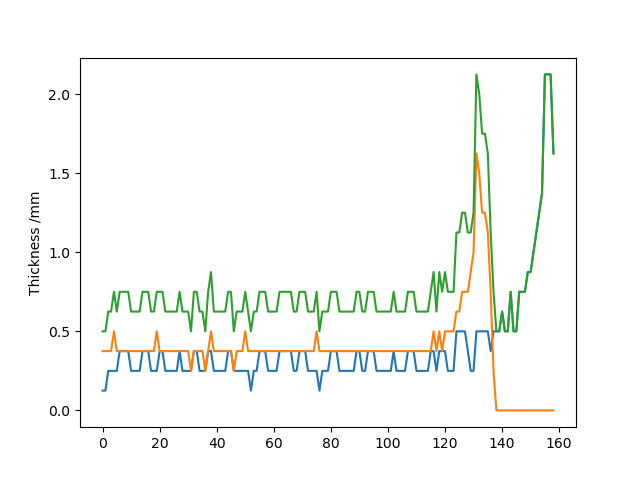

In [16]:
import matplotlib.pyplot as plt
%matplotlib widget
plt.figure()
plt.ylabel("Thickness /mm")
plt.plot(lineThickness23, label = '23')
plt.plot(lineThickness45, label = '45')
plt.plot(lineThickness, label = 'Total')
plt.show()

In [17]:
#theta = 23
geolines=[]
ref0s =[]
ref90s = []
startPts =[]
startVecs =[]
t0 = time.time()
for i in range(len(seeds['pts'])):
    theta = seeds['thetas'][i]
    startPt = seeds['pts'][i]
    startPts.append(startPt)
    ref90 = seeds['ref90s'][i]
    ref90s.append(ref90)
    startFace =seeds['faces'][i]
    ref0 = P3.Cross(ref90,tbm.faces[startFace].normal)
    ref0s.append(ref0)
    startVec = rotAxisAngle(ref0,tbm.faces[startFace].normal,theta)
    startVecs.append(startVec)
    forward = seeds['bFor'][i]
    geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = True, tw = 6.35, forward = forward, maxPathLength = 1000)
    if len(geoline['pts']) < 3:
        geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = True, tw = 6.35, forward = not forward, maxPathLength = 1000)
    geolines.append(geoline)
print('Time taken:',time.time()-t0, 's')

edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached

In [18]:
theta = 45
geolines2=[]
t0 = time.time()

for i in range(len(seeds['pts'])):
    startPt = seeds['pts'][i]
    ref90 = seeds['ref90s'][i]
    startFace =seeds['faces'][i]
    ref0 = P3.Cross(ref90,tbm.faces[startFace].normal)
    startVec = rotAxisAngle(ref0,tbm.faces[startFace].normal,theta)
    forward = seeds['bFor'][i]
    geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = True,tw = 6.35, forward = forward, maxPathLength = 1000)
    if len(geoline['pts']) < 3:
        geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = True, tw = 6.35, forward = not forward, maxPathLength = 1000)
    geolines2.append(geoline)
print('Time taken:',time.time()-t0, 's')

edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on 

In [19]:
CPT = 0.125
thicks = np.zeros(len(tbm.nodes))

for geoline in geolines:
    for n in geoline['nodes']:
        thicks[n.i] += CPT
        
for geoline in geolines2:
    for n in geoline['nodes']:
        thicks[n.i] += CPT

thicks

array([0.75 , 0.75 , 0.625, ..., 0.625, 0.625, 0.625])

In [22]:
ps.init()
#geonodes = []
#geonodes2 = []
#for geoline in geolines:
#    geonodes = geonodes + geoline['pts']
#for geoline in geolines2:
#    geonodes2 = geonodes2 + geoline['pts'] 

ps_surf = ps.register_surface_mesh("my mesh", V, F, smooth_shade=False)
#ps_surf.add_scalar_quantity("thickness", thicks, defined_on='vertices',enabled = True,cmap='coolwarm')
ps_startline = ps.register_curve_network('startline', P3list2array(startPts), 'line')
#ps_geoline = ps.register_curve_network('geoline', P3list2array(geoline['pts']), 'line')
plotlines =[]
#for i in range(len(geolines)):
#    plotlines.append(P3list2array(geolines[i]['pts']))
#ps.register_curve_network('geolines', P3list2array(geonodes), 'line')
#ps.register_curve_network('geolines2', P3list2array(geonodes2), 'line')
ps_startPts = ps.register_point_cloud('startPts', P3list2array(startPts))
ps_SP = ps.register_point_cloud("seedpts", P3list2array(seeds['pts']))
#ps_SP1 = ps.register_point_cloud("Start1", P3list2array([start1]))
ps_startPts.add_vector_quantity("ref90", P3list2array(ref90s))
ps_startPts.add_vector_quantity("ref0", P3list2array(ref0s))
ps_startPts.add_vector_quantity("startVec", P3list2array(startVecs))
ps.show()

ps.clear_user_callback()

In [21]:
ps.init()
#for i in range(len(tbm.bars)):
#    pt1 = tbm.bars[i].GetNodeFore(True).p
#    pt2 = tbm.bars[i].GetNodeFore(False).p
#    nodes = np.array([(pt1.x,pt1.y,pt1.z),(pt2.x,pt2.y,pt2.z)])
#    ps_net = ps.register_curve_network('bar'+str(i), nodes, 'line',radius = 0.002, enabled=False)
ps_surf = ps.register_surface_mesh("my mesh", V, F, smooth_shade=False)
ps_cloud = ps.register_point_cloud("vertices", V)
#ps_SP = ps.register_point_cloud("Start", P3list2array([startPt]))
#ps_SP.add_vector_quantity("ref", np.array([ref90]))
#for i in range(len(geopaths)):
#    ps_geopath = ps.register_curve_network(str(i), P3list2array(geopaths[i]), 'line')
#    ps_geopath.add_scalar_quantity("curvature", np.array(curvs[i]), defined_on='edges', enabled=True,  cmap='coolwarm',vminmax=(-0.1, 0.1))
ps_surf.add_vector_quantity("normals", n, defined_on='faces', color=(1, 0.5, 0.5))
ps.show()

AttributeError: 'TriangleNode' object has no attribute 'shape'

In [4]:
ps.init()

ps_surf = ps.register_surface_mesh("my mesh", V, F, smooth_shade=False, color = (0,1,0))
#ps_SP = ps.register_point_cloud("Start", P3list2array([startPt]))
#ps_SP.add_vector_quantity("ref", np.array([ref90]))


#    ps_geopath.add_scalar_quantity("curvature", np.array(curvs[i]), defined_on='edges', enabled=True,  cmap='coolwarm',vminmax=(-0.1, 0.1))        

#ps.set_user_callback(increment_path)
ps.set_user_callback(draw_paths)



ps.show()

ps.clear_user_callback()

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 4.6 (Core Profile) Mesa 21.2.6
face 1910
calculating 0
edge reached on path 0 deg
edge reached on path 0 deg
calculating 90
PATH FAIL: max path length reached on path 90
PATH FAIL: max path length reached on path 90
face 4132
calculating 0
edge reached on path 0 deg
edge reached on path 0 deg
calculating 90
PATH FAIL: max path length reached on path 90
PATH FAIL: max path length reached on path 90
face 1674
calculating 0
edge reached on path 0 deg
edge reached on path 0 deg
calculating 90
PATH FAIL: max path length reached on path 90
PATH FAIL: max path length reached on path 90
face 1227
calculating 0
edge reached on path 0 deg
edge reached on path 0 deg
calculating 90
PATH FAIL: max path length reached on path 90
PATH FAIL: max path length reached on path 90
face 1633
calculating 0
edge reached on path 0 deg
edge reached on path 0 deg
calculating 90
PATH FAIL: max path length reached on path 90
PATH FAIL: max path length rea

In [13]:
ps.init()

ps_surf = ps.register_surface_mesh("my mesh", V, F, smooth_shade=False)
ps_SP = ps.register_point_cloud("Start", P3list2array([startPt]))
ps_SP.add_vector_quantity("ref", np.array([ref90]))
for i in range(len(geopaths)):
    ps_geopath = ps.register_curve_network(str(i), P3list2array(geopaths[i]), 'line')
    ps_geopath.add_scalar_quantity("curvature", np.array(curvs[i]), defined_on='edges', enabled=True,  cmap='coolwarm',vminmax=(-0.1, 0.1))
ps.show()

NameError: name 'startPt' is not defined